In [2]:
# For Google Colab
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import cv2
import copy
from PIL import Image
from PIL import Image, ImageDraw

In [3]:
# crop image from the dataset (to remove padding)
def crop_image(image_path):
    # Open the image file
    img = Image.open(image_path)
    # Get the dimensions of the image
    width, height = img.size
    # if height of image < 270, then return the image
    if height < 270:
        return img
    # Define the points for cropping
    left = 100
    upper = 100
    right = width - 100
    lower = height - 100
    # Crop the image
    img_cropped = img.crop((left, upper, right, lower))
    # Return the cropped image
    return img_cropped

In [4]:
# crop image for splitting into words
def crop_x_image(img, x_left, x_right):
  width, height = img.size
  img_crop = img.crop((x_left, 0, x_right, height))
  return img_crop

In [5]:
# Boundary coordinates
def get_boundary_coordinates(xml_path):
    root = xml_path.getroot()
    whiteboard_description = root.find('.//WhiteboardDescription')
    # Extract the 'DiagonallyOppositeCoords', 'VerticallyOppositeCoords', and 'HorizontallyOppositeCoords'
    x2 = float(whiteboard_description.find('DiagonallyOppositeCoords').attrib['x']) + 300
    y2 = float(whiteboard_description.find('DiagonallyOppositeCoords').attrib['y']) 
    x1 = float(whiteboard_description.find('VerticallyOppositeCoords').attrib['x'])
    y1 = float(whiteboard_description.find('HorizontallyOppositeCoords').attrib['y'])

    boundary_coords = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]])

    return boundary_coords

In [6]:
# function to get stroke data and points data
def get_stroke_data(xml_path):
    root = xml_path.getroot()
    # Initialize lists to store stroke and point attributes
    stroke_attribs = []
    point_attribs = []

    # Iterate over 'Stroke' elements
    for stroke in root.iter('Stroke'):
        # Append stroke attributes to list
        stroke_attribs.append([float(stroke.attrib['start_time']), float(stroke.attrib['end_time'])]) # Colour, start, end

        points = []

        # Iterate over 'Point' elements within each 'Stroke'
        for point in stroke.iter('Point'):
            # Append point attributes to list
            points.append([float(point.attrib['x']), float(point.attrib['y']), float(point.attrib['time'])])

        point_attribs.append(points)

    return stroke_attribs, point_attribs

In [7]:
# funtion for mapping image to stroke coordinates
def map_image_to_stroke(image_size, boundary_coords, point_attribs):
    # Calculate scale factors and translation distances
    scale_factors = image_size / (boundary_coords.max(axis=0) - boundary_coords.min(axis=0))
    translation_distances = boundary_coords.min(axis=0)

    # Scale and translate point coordinates
    for points in point_attribs:
        for point in points:
            point[:2] = (point[:2] - translation_distances) * scale_factors

    return point_attribs

In [8]:
# Plot the coordinates and saving the image
def plot_coordinates(point_attribs, image_size):
    output_file = 'output.png'
    # Create a white image of the desired size
    image_size = tuple(image_size.astype(int))
    img = Image.new('L', image_size, 'white')

    # Get the drawing context
    draw = ImageDraw.Draw(img)

    # Draw thicker points at the coordinates in point_attribs and join them with lines
    for points in point_attribs:
        prev_point = None
        for point in points:
            x, y = int(point[0]), int(point[1])
            radius = 2  # Adjust as needed
            draw.ellipse((x-radius, y-radius, x+radius, y+radius), fill=12)  # Darken and thicken the points

            # If there is a previous point, draw a line from the previous point to the current point
            if prev_point is not None:
                draw.line([prev_point, (x, y)], fill=15, width=radius*2)

            # Update previous point
            prev_point = (x, y)

    dpi = 60
    fig = plt.figure(figsize=(image_size[0]/dpi, image_size[1]/dpi), dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')  # Don't show axes

    # Display the image
    ax.imshow(img, cmap='gray')

    # Save the figure as an image
    plt.savefig(output_file, dpi=dpi, bbox_inches='tight', pad_inches=0)
    plt.close() 

    # return path of the image
    return output_file

In [9]:
# extract information from xml file
def get_info_xml(xml_path, image_size):
    boundary_coords = get_boundary_coordinates(xml_path)
    stroke_attribs, point_attribs = get_stroke_data(xml_path)
    point_attribs = map_image_to_stroke(image_size, boundary_coords, point_attribs)

    return boundary_coords, stroke_attribs, point_attribs

# Splitting the words

In [10]:
# threshold decides whether the current stroke belongs to the previous word or not
def threshold(a, b):
  # a is distance difference
  # b is time difference (We havent used time difference in our code)
  if a < 60:
    return True
  else:
    return False

In [11]:
def get_words(img_cropped, stroke_attribs, point_attribs, target_image_path, image_size, num):
    word_strokes = [] # storing words -> strokes -> points
    word_stroke_img = [] # storing image file paths
    prevt = 0 # storing end time of last stroke of prev word (for time-thresholding)
    prev_xsep = 0 # storing rightmost pixel of prev word (for x-thresholding)
    img_new = copy.deepcopy(img_cropped)
    for i in range(len(stroke_attribs)):
        pts = copy.deepcopy(point_attribs[i]) # extract next stroke

        if i == 0:
            word_strokes.append([pts]) # create first word and assign this stroke to the word
            continue

        x_pts = [x[0] for x in pts] # extract x-coords for points in current stroke
        x_pts = np.array(x_pts)

        new_xstart = np.min(x_pts) # store leftmost pixel of current stroke

        pts_prev = copy.deepcopy(word_strokes[-1][-1]) # extract previous stroke
        x_pts = [x[0] for x in pts_prev] # extract x-coords for points in prev stroke
        x_pts = np.array(x_pts)

        old_xend = np.max(x_pts) # store rightmost pixel of current stroke

        if threshold(new_xstart - old_xend, stroke_attribs[i][0] - prevt) == True:
            # if stroke identified as part of current word
            word_strokes[-1].append(pts) # append stroke to last word
        else:
            # if stroke identified as not part of current word, i.e. next word
            word_strokes.append([pts]) # create a new word and assign this stroke to the word
            new_xsep = 0.8*(new_xstart) + 0.2*(old_xend) # midpoint b/w prev stroke and next stroke (for image separation)

            # save image for completed word as prev_xsep : new_xsep
            img_new = crop_x_image(img_cropped, prev_xsep, new_xsep)
            img_new.save(target_image_path + f'image_{num}.png')

            # append path to saved image into word_stroke_img
            word_stroke_img.append(f'image_{num}.png')

            prev_xsep = new_xsep # update end-xcoord for completed word (start xcoord for new word)
            num += 1

        prevt = stroke_attribs[i][1] # update end-time for completed word
        # save image for last completed word as prev_xsep : new_xsep
        # append path to saved image into word_stroke_img
    img_new_last = crop_x_image(img_cropped, prev_xsep, image_size[0])
    img_new_last.save(target_image_path + f'image_{num}.png')
    word_stroke_img.append(f'image_{num}.png')
    num+=1
    return word_strokes, word_stroke_img, num

In [12]:
# saving strokes as numpy arrays
def save_strokes(word_strokes, target_xml_path, num):
    for word in word_strokes:
        word_np = []
        for stroke in word:
            i = 0
            for point in stroke:
                p = [point[0], point[1], point[2], 0, 0]
                if i == 0:
                    p[3] = 1
                elif i == len(stroke) - 1:
                    p[4] = 1
                word_np.append(p)
                i += 1
        np.save(target_xml_path + f'stroke_{num}.npy', word_np)
        num += 1
    return num

In [13]:
# function to split words 
def split_words(image_path, xml_path, target_image_path, target_xml_path, num):
    num1 = num
    num2 = num
    xml_path = ET.parse(xml_path)
    img_cropped = crop_image(image_path)
    # Convert the image to grayscale
    img_cropped = img_cropped.convert('L')
    image_size = np.asarray(img_cropped.size)
    boundary_coords, stroke_attribs, point_attribs = get_info_xml(xml_path, image_size)
    # original image and the stroke coordinates are slightly different despite the map, therefore we use the image generated by point_attribs
    # saving the image generated by point_attribs
    output_image_path = plot_coordinates(point_attribs, image_size)
    # opening the image generated by point_attribs
    img_cropped = Image.open(output_image_path)
    word_strokes, word_stroke_img, num1 = get_words(img_cropped, stroke_attribs, point_attribs, target_image_path, image_size, num1)
    num2 = save_strokes(word_strokes, target_xml_path, num2)
    return num1, num2 

In [14]:
# change directory to required directory
import os
os.chdir("C:/") # change directory to required directory

In [15]:
# Splitting words from line images, saving images and strokes to train and test folders
import os
import xml.etree.ElementTree as ET
num = 1
line_images_dir = '../' # directory containing line images
line_strokes_dir = '../' # directory containing line strokes
print('Directory to walk:', line_images_dir)
if not os.listdir(line_images_dir):
    print("Directory is empty")
else:    
    print("Directory is not empty")
for root, dirs, files in os.walk(line_images_dir):
    for file in files:
        if file.endswith(('.tif')):
            relative_path = os.path.relpath(root, line_images_dir)
            xml_file = os.path.join(line_strokes_dir, relative_path, file).replace('.tif', '.xml')
            # if xml file exists, then split the words
            if os.path.exists(xml_file):
                image_path = os.path.join(root, file)
                xml_path = xml_file
                target_image_path = f'IAM-Online/Dataset/Train/Images/' # directory to save images
                target_xml_path = f'IAM-Online/Dataset/Train/Strokes/' # directory to save strokes
                try:
                    num, _ = split_words(image_path, xml_path, target_image_path, target_xml_path, num)
                except Exception as e:
                    print(f"An error occurred with file {image_path}: {e}")
                    
            # if xml file does not exist, then save the image to test folder
            else:
                # save image to test folder
                image_path = os.path.join(root, file)
                target_image_path = f'IAM-Online/Dataset/Test/Images/'
                # save file to test folder
                image = Image.open(image_path)
                image.save(target_image_path + file)

print('done!')

Directory to walk: C:/Users/Anita Dash/Music/IAM-Online/lineImages-all
Directory is not empty
done!


37377


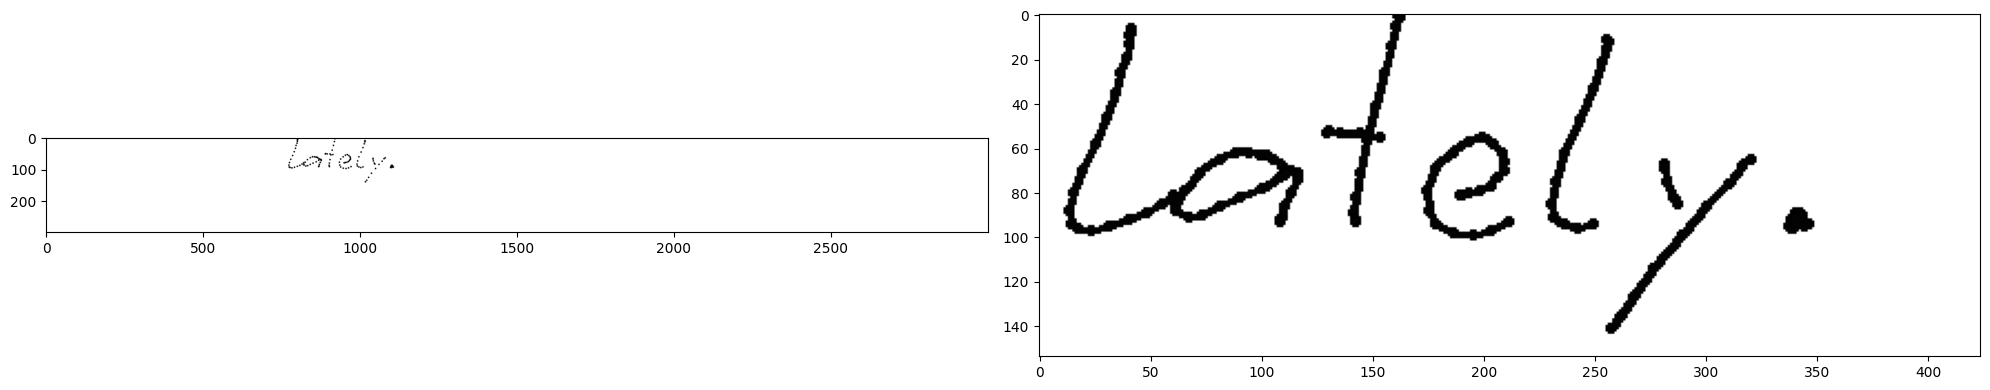

In [76]:
# checking if the image is saved correctly

import random

# randomly select an image from the dataset
num = random.randint(1, 50871)
print(num)
image_path = f'IAM-Online/Dataset/Train/Images/image_{num}.png' # path to image
npy_path = f'IAM-Online/Dataset/Train/Strokes/stroke_{num}.npy' # path to strokes

# load the image and strokes
points = np.load(npy_path)
image = Image.open(image_path)
image_size = image.size
image_size = tuple([3000, 300])

# plot the points
img = Image.new('L', image_size, 'white')
draw = ImageDraw.Draw(img)
prev_point = None
for point in points:
    x, y = int(point[0]), int(point[1])
    radius = 2  # Adjust as needed
    draw.ellipse((x-radius, y-radius, x+radius, y+radius), fill=12)  # Darken and thicken the point

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(image, cmap='gray')
plt.tight_layout()
plt.show()